# SYDE 552 -- Final Project Code: Deep Learning for Digital Pathology

### Due Date: Thursday, April 18th, 2024
### Hafsa Mueen, 20947674

#### Majority of the code used in this Juypter Notebook came from SYDE 552 Assignment 2: Vision and SYDE 552: MLP and SYDE 552: Convolutional Tutorial Juypter Notebooks

### Importing all libraries and data needed:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt                                                        # plotting and visualization
import numpy as np                                                                     # mathematical operations on arrays and matrices
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  # computing confusion matrix
import seaborn as sns                                                                  # graphing confusion matrix

import torch                           # main torch import for torch tensors
import torchvision                     # vision / image processing package built on top of torch
import torch.nn as nn                  # neural network module for building deep learning models
import torch.optim as optim            # optimization module
import torch.nn.functional as F        # functions that can be used; convolution, pooling, activation, dropout, loss, vision

In [ ]:
from google.colab import drive  # authenticating google drive to access image datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# allowing access to mounted google drive
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# accessing the training and testing datasets

%cd /content/drive/MyDrive/traindataset
%cd /content/drive/MyDrive/testdataset

/content/drive/MyDrive/traindataset
/content/drive/MyDrive/testdataset


## Make new folder organization

In [ ]:
!pip install tqdm
from tqdm import tqdm # checks timing stuff
import shutil         # copy and removes files
import os             # operating system
import glob           # searches for specific files

In [ ]:
# Get all the image paths that correspond to the "1" and "0" class in the training folder

train_class_1_files = glob.glob("/content/drive/MyDrive/train/*/1/*.png")
train_class_0_files = glob.glob("/content/drive/MyDrive/train/*/0/*.png")

len(train_class_0_files), len(train_class_1_files)

(5365, 4668)

In [ ]:
# Get all the image paths that correspond to the "1" and "0" class in the testing folder

test_class_1_files = glob.glob("/content/drive/MyDrive/test/*/1/*.png")
test_class_0_files = glob.glob("/content/drive/MyDrive/test/*/0/*.png")

len(test_class_0_files), len(test_class_1_files)

(2138, 2003)

In [ ]:
# Make some new directories in the right format
os.makedirs("/content/drive/MyDrive/traindataset/0", exist_ok=True) # training
os.makedirs("/content/drive/MyDrive/traindataset/1", exist_ok=True)

In [ ]:
os.makedirs("/content/drive/MyDrive/testdataset/0", exist_ok=True)  # testing
os.makedirs("/content/drive/MyDrive/testdataset/1", exist_ok=True)

In [ ]:
# new directory for class 1 training images

for filepath in tqdm(train_class_1_files):
  img_name = filepath.split("/")[-1]       # Just the png name
  new_path = os.path.join("/content/drive/MyDrive/traindataset/1", img_name)
  shutil.copyfile(filepath, new_path)

100%|██████████| 4668/4668 [31:23<00:00,  2.48it/s]


In [ ]:
# new directory for class 0 training images

for filepath in tqdm(train_class_0_files):
  img_name = filepath.split("/")[-1]       # Just the png name
  new_path = os.path.join("/content/drive/MyDrive/traindataset/0", img_name)
  shutil.copyfile(filepath, new_path)

100%|██████████| 5365/5365 [37:15<00:00,  2.40it/s]


In [ ]:
# new directory for class 1 testing images

for filepath in tqdm(test_class_1_files):
  img_name = filepath.split("/")[-1]      # Just the png name
  new_path = os.path.join("/content/drive/MyDrive/testdataset/1", img_name)
  shutil.copyfile(filepath, new_path)

100%|██████████| 2003/2003 [08:42<00:00,  3.84it/s]


In [ ]:
# new directory for class 0 testing images

for filepath in tqdm(test_class_0_files):
  img_name = filepath.split("/")[-1]      # Just the png name
  new_path = os.path.join("/content/drive/MyDrive/testdataset/0", img_name)
  shutil.copyfile(filepath, new_path)

100%|██████████| 2138/2138 [09:36<00:00,  3.71it/s]


## Data Setup and Pre-processing:

In [ ]:
a = torch.Tensor([
   [0.2126, 0.7152, 0.0722],    # R to Y'
   [-0.09991, -0.33609, 0.436], # G to U
   [0.615, -0.55861, -0.05639]  # B to V
])

b = torch.zeros([3, 32, 32])                                                     # adding same sized tensor to resized imgs in transform
b[0,:,:] = 16 / 255                                                              # scaling images - added to R to Y'
b[1,:,:] = 128 /255                                                              # scaling images - added to G to U
b[2,:,:] = 128 / 255                                                             # scaling images - added to B to V

func = lambda img: torch.clip((torch.einsum("dc,chw->dhw", a, img) + b), 0, 1)   # einsum for correct dimension multiplication; clipping for matplotlib range correction
rgb2yuv = torchvision.transforms.Lambda(func)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                   # all inputs to PyTorch neural networks must be torch.Tensor
    torchvision.transforms.Resize((32, 32)),             # resizing images from [3, 50, 50] to [3, 32, 32] tensors
    torchvision.transforms.Normalize(mean=0, std=1),     # normalization of all images to a mean of zero and std.dev of 1
    torchvision.transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of image being flipped horizontally
    torchvision.transforms.RandomVerticalFlip(p=0.5),    # 50% chnace of image being flipped vertically
    rgb2yuv                                              # converts the RBG images to YUV; more similar to how human retina processes colours
])

train_dataset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/traindataset', transform=transform)  # training dataset in google drive is entirely seperate from the test dataset
test_dataset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/testdataset', transform=transform)


# shuffling training data due to folder set up in gdrive
idx = np.arange(len(train_dataset))
np.random.shuffle(idx)
train_idx = idx[4141:8282]

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),      # for the different evaluations different aranges will be chosen - this is for the first train
                                           batch_size=128, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, np.arange(4141)),  # using the entire testing for each evaluation of the network
                                          batch_size=128, shuffle=True, pin_memory=True)

print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 10033
    Root location: /content/drive/MyDrive/traindataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=0, std=1)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Lambda()
           )
Dataset ImageFolder
    Number of datapoints: 4141
    Root location: /content/drive/MyDrive/testdataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=0, std=1)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Lambda()
           )


## Creating the Convolutional Neural Network:

In [ ]:
# creating the network

device = "cuda" if torch.cuda.is_available() else "cpu" # CPU to T4 GPU to speed up runtime

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)                       # set the size of the convolution to 5x5, and have 32 of them
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=3)
        self.fc1 = nn.Linear(256, 64)                                      # the weights from the input to the new learned features (hidden layer)
        self.flatten = nn.Flatten()                                        # used for flattening the values
        self.fc2 = nn.Linear(64, 2)                                        # the weights from the hidden layer to the output

    def forward(self, x):                                                  # the processing the network will do
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=2))   # make sure to do max pooling after the convolution layers
        x = F.relu(F.avg_pool2d(self.conv2(x), kernel_size=3, stride=2))
        x = F.relu(F.avg_pool2d(self.conv3(x), kernel_size=3, stride=2))
        x = F.relu(self.fc1(self.flatten(x)))                              # flattening the input values
        x = self.fc2(x)
        return F.softmax(x, dim = -1)

network = Net().to(device)                              # neural network creation
optimizer = optim.Adam(network.parameters(), lr=0.001)  # change optimizer to adam
loss_fn = nn.CrossEntropyLoss()                         # setup the appropriate loss function for this task

print(network)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


## Training and Testing the Network (#1):

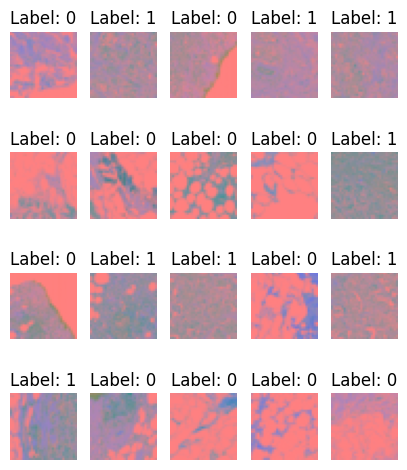


Each image is a torch.Tensor and has shape torch.Size([3, 32, 32]).


In [ ]:
# visualizing some of the testing data after transformations have been apllied

test_imgs = (len(test_dataset))
plot_test_images = []
plot_test_labels = []

fig, axs = plt.subplots(4, 5, figsize=(5, 6))
for i, ax in enumerate(axs.flatten()):
    idx = np.random.randint(0, test_imgs)
    (test_image, test_label) = test_dataset[idx]  # randomly chooses imgs from test dataset

    # Save this data for later
    plot_test_images.append(test_image)
    plot_test_labels.append(test_label)

    ax.imshow(test_image.permute(1,2,0))    # permuting the dimensions of the images
    ax.set_title(f"Label: {test_label}")    # labels should be either 0 or 1
    ax.axis("off")
plt.show()

plot_testing = torch.cat(plot_test_images)  # combine all the images into a single batch for later

print("")
print(f"Each image is a torch.Tensor and has shape {test_image.shape}.")

In [ ]:
# training the network

accuracy_trained = []                                 # variables to keep track of training
all_train_targets = []                                # the correct labels of each image
all_train_predictions = []                            # the labels predicted of each image from the model
train_losses = []

accuracy_tested = []                                  # variables to keep track of testing
all_test_targets = []                                 # the correct labels of each image
all_test_predictions = []                             # the labels predicted of each image from the model
test_losses = []

def continue_training():
    network.train()                                                # configure the network for training
    for i in range(10):                                            # train the network 10 times
        correct = 0
        train_loss = 0
        for data, target in train_loader:                          # working in batchs of 128
            data, target = data.to(device), target.to(device)      # putting network on T4 GPU (if available)
            optimizer.zero_grad()                                  # initialize the learning system; zero the parameter gradients
            output = network(data)                                 # feed in the data
            loss = loss_fn(output, target)                         # compute how wrong the output is
            loss.backward()                                        # change the weights to reduce error (backpropagation)
            optimizer.step()                                       # update the learning rule

            # moving output and target back to CPU
            output = output.cpu()
            target = target.cpu()

            train_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]              # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()     # compute the number of correct outputs
            all_train_predictions2.extend(pred.tolist())            # train dataset labels predicted by the network
            all_train_targets2.extend(target.tolist())              # the true train dataset labels

    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_trained.append(score)
    training_loss = float(train_loss / len(train_loader.dataset))
    train_losses.append(training_loss)
    print('Iteration', len(accuracy_trained), 'Training accuracy:', score, 'Train Loss:', training_loss)

    correct = 0
    test_loss = 0
    network.eval()
    for data, target in test_loader:                           # go through the test data once (in groups of 128)
      with torch.no_grad():                                    # telling torch not to track gradients
          data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
          output = network(data)                               # feed in the data

          # moving output and target back to CPU
          output = output.cpu()
          target = target.cpu()

          loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

          test_loss2 += loss.item()
          all_test_predictions2.extend(pred.tolist())
          all_test_targets2.extend(target.tolist())

    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_tested.append(score)
    testing_loss = float(test_loss/len(test_loader.dataset))
    test_losses.append(test_loss)
    print('Iteration', len(accuracy_tested), 'Testing accuracy:', score, 'Test Loss:', testing_loss)

# training the network for 10 iterations
for i in range(10):
   continue_training()

Iteration 1 Training accuracy: 0.7952185273170471 Train Loss: 0.00405100963162328
Iteration 1 Testing accuracy: 0.7981163859367371 Test Loss: 0.004064349492256609
Iteration 2 Training accuracy: 0.8133301138877869 Train Loss: 0.003912641889258475
Iteration 2 Testing accuracy: 0.799565315246582 Test Loss: 0.00402854175361508
Iteration 3 Training accuracy: 0.8138130903244019 Train Loss: 0.0038917607600146
Iteration 3 Testing accuracy: 0.8106737732887268 Test Loss: 0.003974437310597195
Iteration 4 Training accuracy: 0.8157449960708618 Train Loss: 0.003876109762025956
Iteration 4 Testing accuracy: 0.8031876087188721 Test Loss: 0.004031805341815465
Iteration 5 Training accuracy: 0.8227481245994568 Train Loss: 0.003860527645473577
Iteration 5 Testing accuracy: 0.800531268119812 Test Loss: 0.003977582344425038
Iteration 6 Training accuracy: 0.8193672895431519 Train Loss: 0.0038819825971682155
Iteration 6 Testing accuracy: 0.8101907968521118 Test Loss: 0.003931565824207894
Iteration 7 Training 

mean training accuracy: 0.8184254944324494
mean testing accuracy: 0.8070272922515869


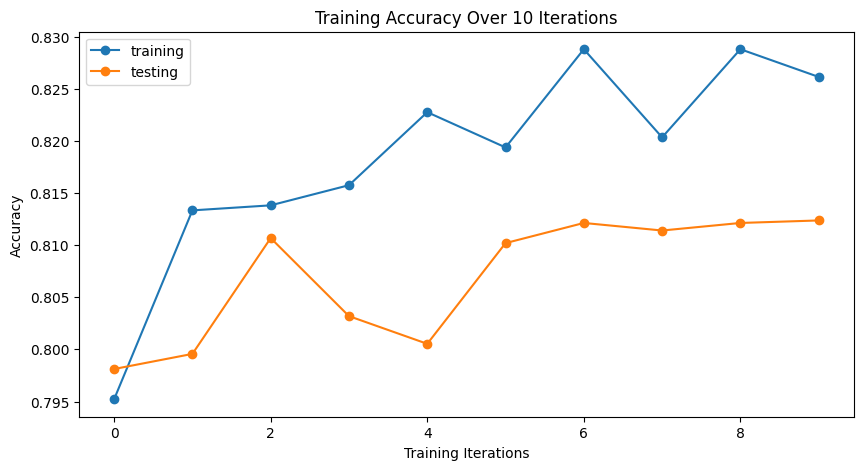

In [ ]:
# plotting the trained networks training and testing data

train_avg = np.mean(accuracy_trained)
test_avg = np.mean(accuracy_tested)
print(f"mean training accuracy: {train_avg}")
print(f"mean testing accuracy: {test_avg}")

plt.figure(figsize=(10,5))
plt.title('Training Accuracy Over 10 Iterations')
plt.plot(accuracy_trained, marker='o', linestyle = 'solid', label='training')
plt.plot(accuracy_tested, marker='o', linestyle = 'solid', label='testing')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

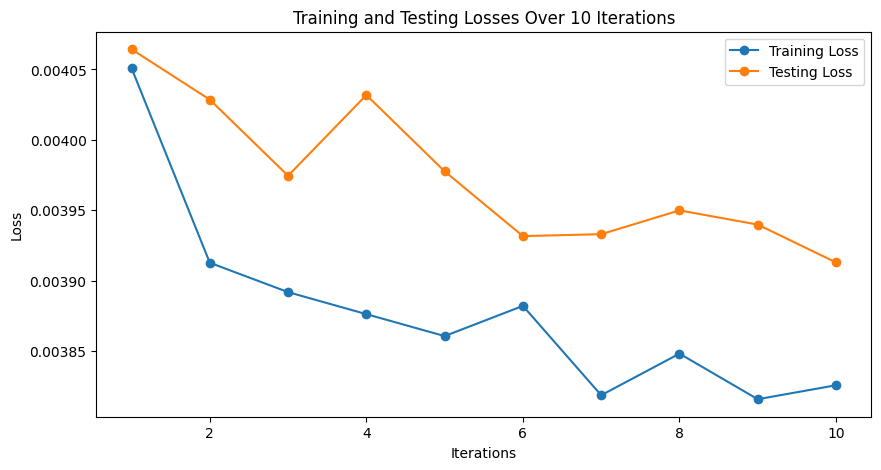

In [6]:
# plotting the correct losses for the 1st network training; not abt to re-run my whole code just for a graph sooo

iters = np.array([1,2,3,4,5,6,7,8,9,10])

train_losses = np.array([0.00405100963162328, 0.003912641889258475,
                         0.0038917607600146, 0.003876109762025956,
                         0.003860527645473577, 0.0038819825971682155,
                         0.0038185089258029534, 0.0038480559025257572,
                         0.003815662850794715, 0.003825596574423135])

test_losses = np.array([0.004064349492256609, 0.00402854175361508,
                        0.003974437310597195, 0.004031805341815465,
                        0.003977582344425038, 0.003931565824207894,
                        0.003932930217852082, 0.003949833122090826,
                        0.003939745931975423, 0.003912832506092756])

plt.figure(figsize=(10, 5))
plt.title('Training and Testing Losses Over 10 Iterations')
plt.plot(iters, train_losses, marker='o', linestyle = 'solid', label='Training Loss')
plt.plot(iters, test_losses, marker='o', linestyle = 'solid', label='Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# testing / evaluating the network

accuracy_tested = []       # variables to keep track of testing
all_test_targets = []      # the correct labels of each image
all_test_predictions = []  # the labels predicted of each image from the model

def test_network():
  for i in range(1):
    correct = 0
    test_loss = 0
    network.eval()
    for data, target in test_loader:                           # go through the test data once (in groups of 128)
        with torch.no_grad():                                  # telling torch not to track gradients
          data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
          output = network(data)                               # feed in the data

          # moving output and target back to CPU
          output = output.cpu()
          target = target.cpu()

          loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

          test_loss2 += loss.item()
          all_test_predictions2.extend(pred.tolist())
          all_test_targets2.extend(target.tolist())

  # update the list of testing accuracy values
  score = float(correct/len(test_loader.dataset))
  accuracy_tested.append(score)
  testing_loss = float(test_loss2/len(test_loader.dataset))
  print('Iteration', len(accuracy_tested), 'Testing accuracy:', score, 'Test Loss:', testing_loss)

for i in range(1):
    test_network()

y_true = all_test_targets
y_pred = all_test_predictions

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm_test = confusion_matrix(y_true, y_pred)        # confusion matrix for testing images
precision_score = precision_score(y_true, y_pred) # precision score for testing images
recall_score = recall_score(y_true, y_pred)       # recall score for testing images
f1_score = f1_score(y_true, y_pred)               # F1 score for testing images

print(f"precision score: {precision_score}")
print(f"recall score: {recall_score}")
print(f"f-score: {f1_score}")

Iteration 1 Testing accuracy: 0.8097078204154968 Test Loss: 0.003931072362233291
precision score: 0.8146038322112895
recall score: 0.7853220169745382
f-score: 0.7996949669547534


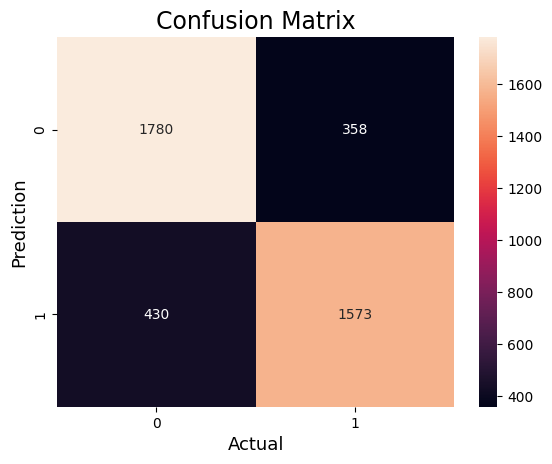

In [ ]:
# displaying confusion matrix for the tested network

sns.heatmap(cm_test,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

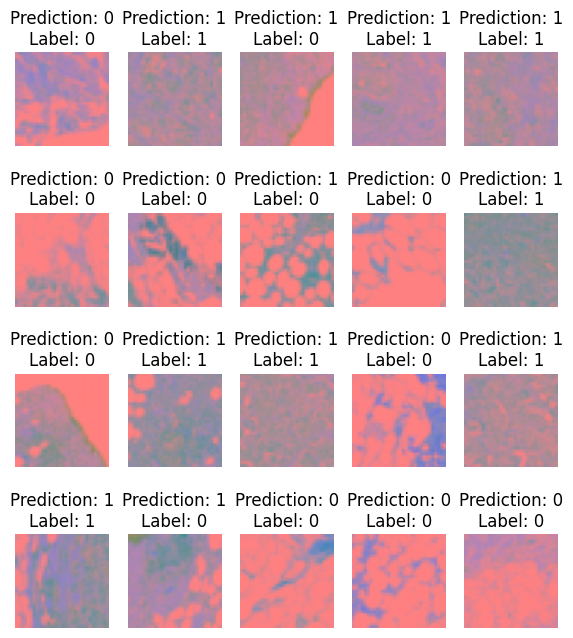

In [ ]:
# visualizing the networks predictions on the examples from earlier

plot_testing = plot_testing.view(20, 3, 32, 32)

network.eval()
with torch.no_grad():
    plot_outputs = network(plot_testing)
    plot_preds = torch.argmax(plot_outputs, dim=-1)

# plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for i, ax in enumerate(axs.flatten()):
    image = plot_testing[i]
    label = plot_test_labels[i]
    pred = plot_preds[i]

    ax.imshow(image.permute(1,2,0))                      # permuting the dimensions of the images
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()

## Training and Testing the Network (#2):

In [ ]:
# shuffling training data due to folder set up in gdrive

idx = np.arange(len(train_dataset))
np.random.shuffle(idx)
train_idx = idx[5892:10033]

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),
                                           batch_size=128, shuffle=True, pin_memory=True)

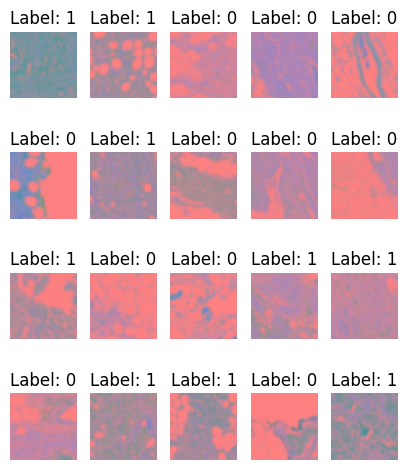


Each image is a torch.Tensor and has shape torch.Size([3, 32, 32]).


In [ ]:
# visualizing some of the testing data after transformations have been applied

test_imgs = (len(test_dataset))
plot_test_images = []
plot_test_labels = []

fig, axs = plt.subplots(4, 5, figsize=(5, 6))
for i, ax in enumerate(axs.flatten()):
    idx = np.random.randint(0, test_imgs)
    (test_image, test_label) = test_dataset[idx]  # randomly chooses imgs from test dataset

    # Save this data for later
    plot_test_images.append(test_image)
    plot_test_labels.append(test_label)

    ax.imshow(test_image.permute(1,2,0))    # permuting the dimensions of the images
    ax.set_title(f"Label: {test_label}")    # labels should be either 0 or 1
    ax.axis("off")
plt.show()

plot_testing = torch.cat(plot_test_images)  # combine all the images into a single batch for later

print("")
print(f"Each image is a torch.Tensor and has shape {test_image.shape}.")

In [ ]:
# training the network

accuracy_trained2 = []                                 # variables to keep track of training
all_train_targets2 = []                                # the correct labels of each image
all_train_predictions2 = []                            # the labels predicted of each image from the model
train_losses2 = []

accuracy_tested2 = []                                  # variables to keep track of testing
all_test_targets2 = []                                 # the correct labels of each image
all_test_predictions2 = []                             # the labels predicted of each image from the model
test_losses2 = []

def continue_training():
    network.train()                                                # configure the network for training
    for i in range(10):                                            # train the network 10 times
        correct = 0
        train_loss2 = 0
        for data, target in train_loader:                          # working in batchs of 128
            data, target = data.to(device), target.to(device)      # putting network on T4 GPU (if available)
            optimizer.zero_grad()                                  # initialize the learning system; zero the parameter gradients
            output = network(data)                                 # feed in the data
            loss = loss_fn(output, target)                         # compute how wrong the output is
            loss.backward()                                        # change the weights to reduce error (backpropagation)
            optimizer.step()                                       # update the learning rule

            # moving output and target back to CPU
            output = output.cpu()
            target = target.cpu()

            train_loss2 += loss.item()
            pred = output.data.max(1, keepdim=True)[1]              # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()     # compute the number of correct outputs
            all_train_predictions2.extend(pred.tolist())            # train dataset labels predicted by the network
            all_train_targets2.extend(target.tolist())              # the true train dataset labels

    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_trained2.append(score)
    training_loss2 = float(train_loss2 / len(train_loader.dataset))
    train_losses2.append(training_loss2)
    print('Iteration', len(accuracy_trained2), 'Training accuracy:', score, 'Train Loss:', training_loss2)

    correct = 0
    test_loss2 = 0
    network.eval()
    for data, target in test_loader:                           # go through the test data once (in groups of 128)
      with torch.no_grad():                                    # telling torch not to track gradients
          data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
          output = network(data)                               # feed in the data

          # moving output and target back to CPU
          output = output.cpu()
          target = target.cpu()

          loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

          test_loss2 += loss.item()
          all_test_predictions2.extend(pred.tolist())
          all_test_targets2.extend(target.tolist())

    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_tested2.append(score)
    testing_loss2 = float(test_loss2/len(test_loader.dataset))
    test_losses2.append(test_loss2)
    print('Iteration', len(accuracy_tested2), 'Testing accuracy:', score, 'Test Loss:', testing_loss2)

# training the network for 10 iterations
for i in range(10):
   continue_training()

Iteration 1 Training accuracy: 0.8278193473815918 Train Loss: 0.003826402100754429
Iteration 1 Testing accuracy: 0.8039121031761169 Test Loss: 0.003965569928601524
Iteration 2 Training accuracy: 0.8244385123252869 Train Loss: 0.003827897693707269
Iteration 2 Testing accuracy: 0.808983325958252 Test Loss: 0.003930788423323568
Iteration 3 Training accuracy: 0.8203332424163818 Train Loss: 0.003829121798370461
Iteration 3 Testing accuracy: 0.8157449960708618 Test Loss: 0.003901166490989156
Iteration 4 Training accuracy: 0.8212991952896118 Train Loss: 0.0038709735717787257
Iteration 4 Testing accuracy: 0.8128471374511719 Test Loss: 0.003902015990319675
Iteration 5 Training accuracy: 0.8200917840003967 Train Loss: 0.003868572653217956
Iteration 5 Testing accuracy: 0.8152620196342468 Test Loss: 0.003905216022782555
Iteration 6 Training accuracy: 0.8343395590782166 Train Loss: 0.0037823385358634015
Iteration 6 Testing accuracy: 0.8208162188529968 Test Loss: 0.003906060872921993
Iteration 7 Tra

mean training accuracy: 0.8289060592651367
mean testing accuracy: 0.8085969507694244


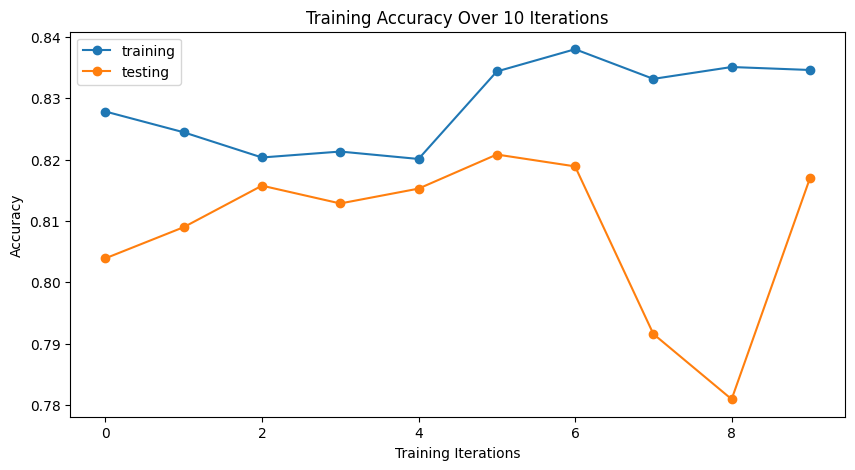

In [ ]:
# plotting the trained network, training and testing data

train_avg2 = np.mean(accuracy_trained2)
test_avg2 = np.mean(accuracy_tested2)
print(f"mean training accuracy: {train_avg2}")
print(f"mean testing accuracy: {test_avg2}")

plt.figure(figsize=(10,5))
plt.title('Training Accuracy Over 10 Iterations')
plt.plot(accuracy_trained2, marker='o', linestyle = 'solid', label='training')
plt.plot(accuracy_tested2, marker='o', linestyle = 'solid', label='testing')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

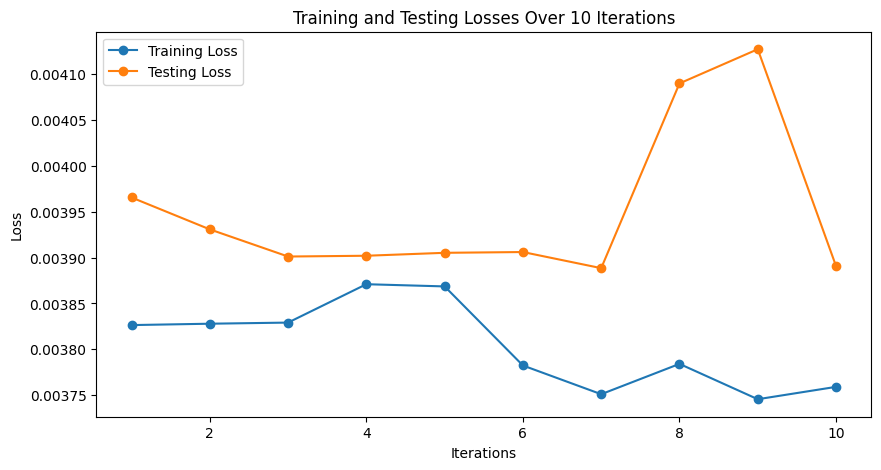

In [5]:
# plotting the correct losses for the 2nd network training; not abt to re-run my whole code just for a graph sooo

iters = np.array([1,2,3,4,5,6,7,8,9,10])

train_losses2 = np.array([0.003826402100754429, 0.003827897693707269,
                          0.003829121798370461, 0.0038709735717787257,
                          0.003868572653217956, 0.0037823385358634015,
                          0.0037510206059711737, 0.0037840927562630714,
                          0.0037455530852921427, 0.0037590389636310796])

test_losses2 = np.array([0.003965569928601524, 0.003930788423323568,
                         0.003901166490989156,0.003902015990319675,
                         0.003905216022782555, 0.003906060872921993,
                         0.003888482295842137, 0.004089944908452535,
                         0.004127236199649571, 0.003890709826923804])

plt.figure(figsize=(10, 5))
plt.title('Training and Testing Losses Over 10 Iterations')
plt.plot(iters, train_losses2, marker='o', linestyle = 'solid', label='Training Loss')
plt.plot(iters, test_losses2, marker='o', linestyle = 'solid', label='Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# testing / evaluating the network

accuracy_tested2 = []       # variables to keep track of testing
all_test_targets2 = []      # the correct labels of each image
all_test_predictions2 = []  # the labels predicted of each image from the model

def test_network():
  for i in range(1):
    correct = 0
    test_loss2 = 0
    network.eval()
    for data, target in test_loader:                           # go through the test data once (in groups of 128)
        with torch.no_grad():                                  # telling torch not to track gradients
          data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
          output = network(data)                               # feed in the data

          # moving output and target back to CPU
          output = output.cpu()
          target = target.cpu()

          loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

          test_loss2 += loss.item()
          all_test_predictions2.extend(pred.tolist())
          all_test_targets2.extend(target.tolist())

  # update the list of testing accuracy values
  score = float(correct/len(test_loader.dataset))
  accuracy_tested2.append(score)
  testing_loss2 = float(test_loss2/len(test_loader.dataset))
  print('Iteration', len(accuracy_tested2), 'Testing accuracy:', score, 'Test Loss:', testing_loss2)

for i in range(1):
    test_network()

y_true = all_test_targets2
y_pred = all_test_predictions2

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm_test2 = confusion_matrix(y_true, y_pred)        # confusion matrix for testing images
precision_score2 = precision_score(y_true, y_pred) # precision score for testing images
recall_score2 = recall_score(y_true, y_pred)       # recall score for testing images
f1_score2 = f1_score(y_true, y_pred)               # F1 score for testing images

print(f"precision score: {precision_score2}")
print(f"recall score: {recall_score2}")
print(f"f-score: {f1_score2}")

Iteration 1 Testing accuracy: 0.8179183602333069 Test Loss: 0.003887958937985573
precision score: 0.785812356979405
recall score: 0.8572141787319022
f-score: 0.8199617956064947


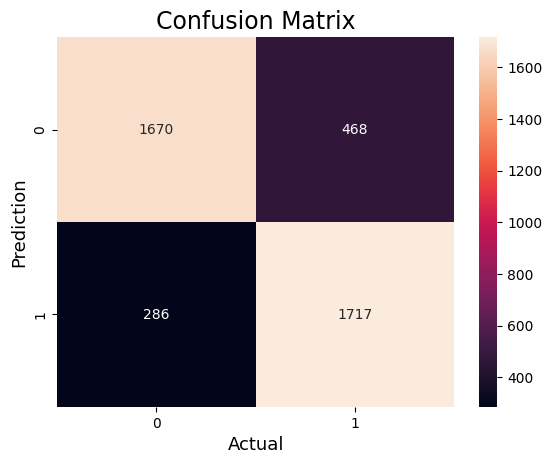

In [ ]:
# displaying confusion matrix for the tested network

sns.heatmap(cm_test2,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

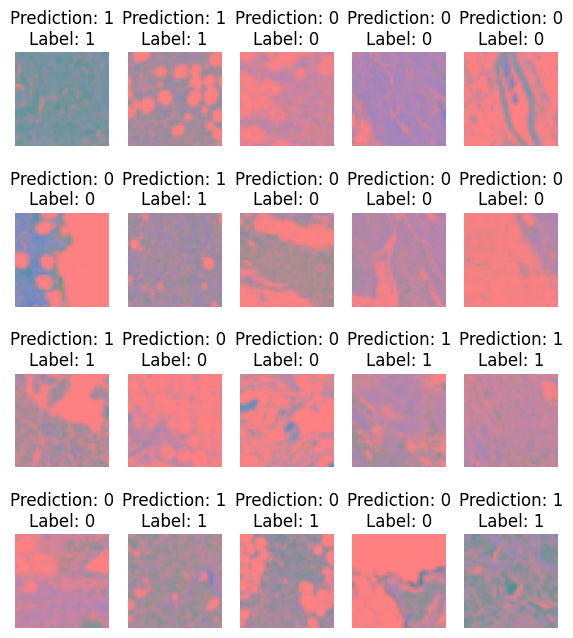

In [ ]:
# visualizing the networks predictions on the examples from earlier

plot_testing = plot_testing.view(20, 3, 32, 32)

network.eval()
with torch.no_grad():
    plot_outputs = network(plot_testing)
    plot_preds = torch.argmax(plot_outputs, dim=-1)

# plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for i, ax in enumerate(axs.flatten()):
    image = plot_testing[i]
    label = plot_test_labels[i]
    pred = plot_preds[i]

    ax.imshow(image.permute(1,2,0))                      # permuting the dimensions of the images
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()

## Training and Testing the Network (#3):

In [ ]:
# shuffling training data due to folder set up in gdrive
idx = np.arange(len(train_dataset))
np.random.shuffle(idx)
train_idx = idx[:4141]

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),
                                           batch_size=128, shuffle=True, pin_memory=True)

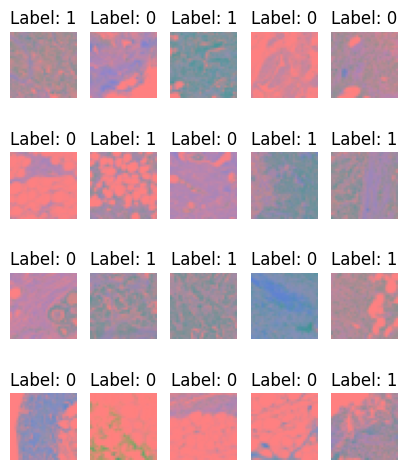


Each image is a torch.Tensor and has shape torch.Size([3, 32, 32]).


In [ ]:
# visualizing some of the testing data after transformations have been applied

test_imgs = (len(test_dataset))
plot_test_images = []
plot_test_labels = []

fig, axs = plt.subplots(4, 5, figsize=(5, 6))
for i, ax in enumerate(axs.flatten()):
    idx = np.random.randint(0, test_imgs)
    (test_image, test_label) = test_dataset[idx]  # randomly chooses imgs from test dataset

    # Save this data for later
    plot_test_images.append(test_image)
    plot_test_labels.append(test_label)

    ax.imshow(test_image.permute(1,2,0))    # permuting the dimensions of the images
    ax.set_title(f"Label: {test_label}")    # labels should be either 0 or 1
    ax.axis("off")
plt.show()

plot_testing = torch.cat(plot_test_images)  # combine all the images into a single batch for later

print("")
print(f"Each image is a torch.Tensor and has shape {test_image.shape}.")

In [ ]:
# training the network

accuracy_trained = []                                 # variables to keep track of training
all_train_targets = []                                # the correct labels of each image
all_train_predictions = []                            # the labels predicted of each image from the model
train_losses = []

accuracy_tested = []                                  # variables to keep track of testing
all_test_targets = []                                 # the correct labels of each image
all_test_predictions = []                             # the labels predicted of each image from the model
test_losses = []

def continue_training():
    network.train()                                                # configure the network for training
    for i in range(10):                                            # train the network 10 times
        correct = 0
        train_loss = 0
        for data, target in train_loader:                          # working in batchs of 128
            data, target = data.to(device), target.to(device)      # putting network on T4 GPU (if available)
            optimizer.zero_grad()                                  # initialize the learning system; zero the parameter gradients
            output = network(data)                                 # feed in the data
            loss = loss_fn(output, target)                         # compute how wrong the output is
            loss.backward()                                        # change the weights to reduce error (backpropagation)
            optimizer.step()                                       # update the learning rule

            # moving output and target back to CPU
            output = output.cpu()
            target = target.cpu()

            train_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]             # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()    # compute the number of correct outputs
            all_train_predictions.extend(pred.tolist())            # train dataset labels predicted by the network
            all_train_targets.extend(target.tolist())              # the true train dataset labels

    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_trained.append(score)
    training_loss = float(train_loss / len(train_loader.dataset))
    train_losses.append(training_loss)
    print('Iteration', len(accuracy_trained), 'Training accuracy:', score, 'Train Loss:', training_loss)

    correct = 0
    test_loss = 0
    network.eval()
    for data, target in test_loader:                           # go through the test data once (in groups of 128)
      with torch.no_grad():                                    # telling torch not to track gradients
          data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
          output = network(data)                               # feed in the data

          # moving output and target back to CPU
          output = output.cpu()
          target = target.cpu()

          loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

          test_loss += loss.item()
          all_test_predictions.extend(pred.tolist())
          all_test_targets.extend(target.tolist())

    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_tested.append(score)
    testing_loss = float(test_loss/len(test_loader.dataset))
    test_losses.append(testing_loss)
    print('Iteration', len(accuracy_tested), 'Testing accuracy:', score, 'Test Loss:', testing_loss)

# training the network for 10 iterations
for i in range(10):
    continue_training()

Iteration 1 Training accuracy: 0.8423086404800415 Train Loss: 0.003706756291024439
Iteration 1 Testing accuracy: 0.798599362373352 Test Loss: 0.00406070330297852
Iteration 2 Training accuracy: 0.8423086404800415 Train Loss: 0.0037111024138605617
Iteration 2 Testing accuracy: 0.8099492788314819 Test Loss: 0.003922480577951582
Iteration 3 Training accuracy: 0.8526926040649414 Train Loss: 0.0036378028498729974
Iteration 3 Testing accuracy: 0.8092248439788818 Test Loss: 0.003974580269624461
Iteration 4 Training accuracy: 0.8548659682273865 Train Loss: 0.003639225739840867
Iteration 4 Testing accuracy: 0.8094663023948669 Test Loss: 0.003935336541277405
Iteration 5 Training accuracy: 0.8439990282058716 Train Loss: 0.003706423103794963
Iteration 5 Testing accuracy: 0.8150205016136169 Test Loss: 0.003937352512574259
Iteration 6 Training accuracy: 0.8558319211006165 Train Loss: 0.0036129851584214574
Iteration 6 Testing accuracy: 0.8155034780502319 Test Loss: 0.0039122526166635386
Iteration 7 Tr

mean training accuracy: 0.8496739983558654
mean testing accuracy: 0.8092006742954254


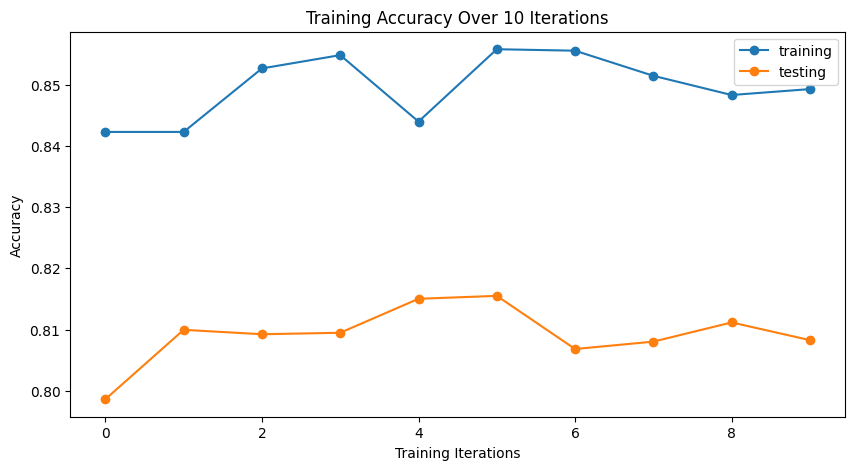

In [ ]:
# plotting the trained network, training and testing data

train_avg = np.mean(accuracy_trained)
test_avg = np.mean(accuracy_tested)
print(f"mean training accuracy: {train_avg}")
print(f"mean testing accuracy: {test_avg}")

plt.figure(figsize=(10,5))
plt.title('Training Accuracy Over 10 Iterations')
plt.plot(accuracy_trained, marker='o', linestyle = 'solid', label='training')
plt.plot(accuracy_tested, marker='o', linestyle = 'solid', label='testing')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

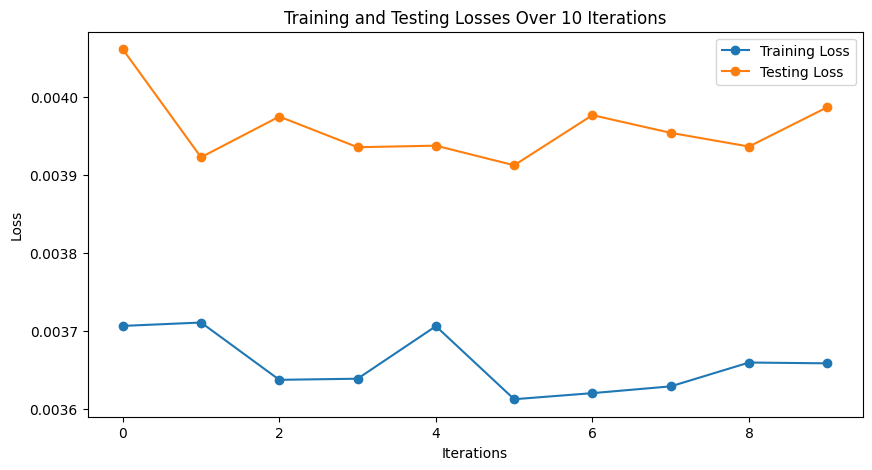

In [ ]:
# plotting losses
plt.figure(figsize=(10, 5))
plt.title('Training and Testing Losses Over 10 Iterations')
plt.plot(train_losses, marker='o', linestyle = 'solid', label='Training Loss')
plt.plot(test_losses, marker='o', linestyle = 'solid', label='Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# testing / evaluating the network

accuracy_tested = []       # variables to keep track of testing
all_test_targets = []      # the correct labels of each image
all_test_predictions = []  # the labels predicted of each image from the model

def test_network():
  correct = 0
  test_loss = 0
  network.eval()
  for data, target in test_loader:                           # go through the test data once (in groups of 128)
      with torch.no_grad():                                  # telling torch not to track gradients
        data, target = data.to(device), target.to(device)    # putting network on T4 GPU (if available)
        output = network(data)                               # feed in the data

        # moving output and target back to CPU
        output = output.cpu()
        target = target.cpu()

        loss = loss_fn(output, target)                       # compute loss b/w ouputs and targets
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest to take as the prediction
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

        test_loss += loss.item()
        all_test_predictions.extend(pred.tolist())
        all_test_targets.extend(target.tolist())

  # update the list of testing accuracy values
  score = float(correct/len(test_loader.dataset))
  accuracy_tested.append(score)
  testing_loss = float(test_loss/len(test_loader.dataset))
  print('Iteration', len(accuracy_tested), 'Testing accuracy:', score, 'Test Loss:', testing_loss)

for i in range(1):
    test_network()

y_true = all_test_targets
y_pred = all_test_predictions

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm_test = confusion_matrix(y_true, y_pred)   # confusion matrix for testing images
precision = precision_score(y_true, y_pred)  # precision score for testing images
recall = recall_score(y_true, y_pred)        # recall score for testing images
f1 = f1_score(y_true, y_pred)                # F1 score for testing images

print(f"precision score: {precision}")
print(f"recall score: {recall}")
print(f"f-score: {f1}")

Iteration 1 Testing accuracy: 0.8072929382324219 Test Loss: 0.003976181807998182
precision score: 0.7693339293696916
recall score: 0.8592111832251622
f-score: 0.8117924528301887


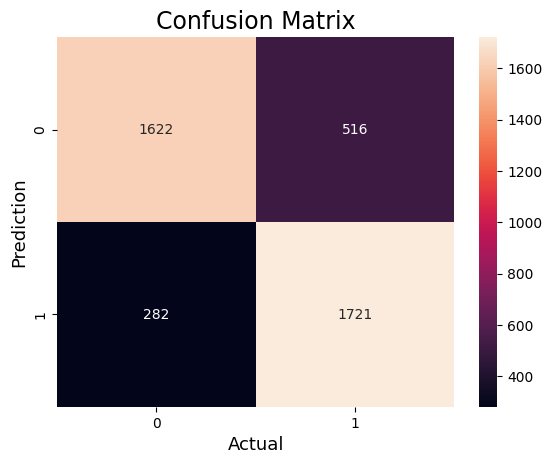

In [ ]:
# displaying confusion matrix for the tested network
sns.heatmap(cm_test,
            annot=True,
            fmt='g',
            xticklabels=['0','1'],
            yticklabels=['0','1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

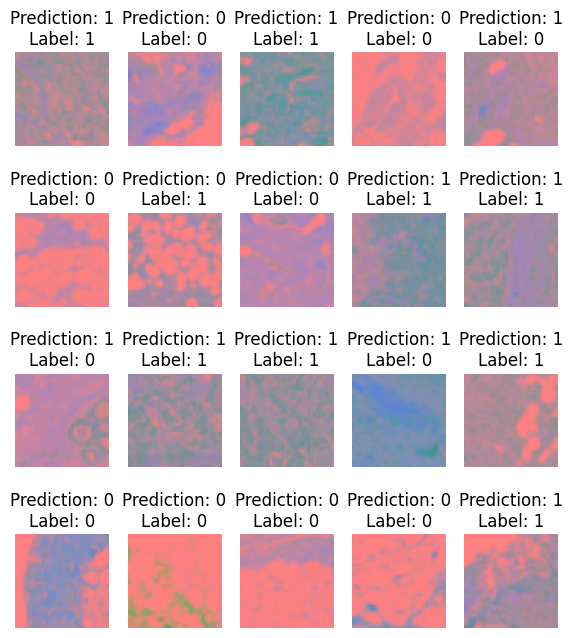

In [ ]:
# visualizing the networks predictions on the examples from earlier

plot_testing = plot_testing.view(20, 3, 32, 32)

network.eval()
with torch.no_grad():
    plot_outputs = network(plot_testing)
    plot_preds = torch.argmax(plot_outputs, dim=-1)

# plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for i, ax in enumerate(axs.flatten()):
    image = plot_testing[i]
    label = plot_test_labels[i]
    pred = plot_preds[i]

    ax.imshow(image.permute(1,2,0))                      # permuting the dimensions of the images
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()